**Research Topics in Computer Vision :: Evaluating the CenterMask** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyyaml==5.1
!gcc --version

     |████████████████████████████████| 276kB 3.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=891f83f4565bad3c336f0adcaf10af64e321c0a94c799ba290d8010e245fbf84
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo


Cloning into 'detectron2_repo'...
remote: Enumerating objects: 12237, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 12237 (delta 61), reused 120 (delta 52), pack-reused 12093
Receiving objects: 100% (12237/12237), 4.85 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (8898/8898), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 153kB 14.2MB/s 
     |████████████████████████████████| 133kB 28.7MB/s 
     |████████████████████████████████| 112kB 29.8MB/s 
     |████████████████████████████████| 727kB 36.7MB/s 
     |████████████████████████████████| 747kB 50.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210518-cp37-none-any.whl size=60362 sha256=0b45b7da430dc76db35ce4a2a1396b2167f85b8857aaa4fa6ff3d80b3467234f
  Stored in directory: /root/.cache/pip/wheels/3b

In [1]:
!git clone https://github.com/youngwanLEE/centermask2.git

Cloning into 'centermask2'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 95.99 KiB | 260.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
import matplotlib.pyplot as plt
import os, json, cv2, random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [4]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2_repo.projects import TensorMask
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances

In [5]:
%cd /content/centermask2
from centermask.config import get_cfg
!wget https://dl.dropbox.com/s/tczecsdxt10uai5/centermask2-V-39-eSE-FPN-ms-3x.pth

/content/centermask2
--2021-05-27 17:01:57--  https://dl.dropbox.com/s/tczecsdxt10uai5/centermask2-V-39-eSE-FPN-ms-3x.pth
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.82.15, 2620:100:6030:15::a27d:500f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.82.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/tczecsdxt10uai5/centermask2-V-39-eSE-FPN-ms-3x.pth [following]
--2021-05-27 17:01:57--  https://dl.dropboxusercontent.com/s/tczecsdxt10uai5/centermask2-V-39-eSE-FPN-ms-3x.pth
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.82.15, 2620:100:6030:15::a27d:500f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.82.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210675187 (201M) [application/octet-stream]
Saving to: ‘centermask2-V-39-eSE-FPN-ms-3x.pth’

centermask2-V-39-eS 100%[===================>] 200.92M  16.9MB/s    in 13s     



In [6]:
cfg = get_cfg()
# add_tensormask_config(cfg)
cfg.merge_from_file("/content/centermask2/configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "/content/centermask2/centermask2-V-39-eSE-FPN-ms-3x.pth"
predictor = DefaultPredictor(cfg)

WARNING [05/27 17:03:49 d2.config.compat]: Config '/content/centermask2/configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


***Registering the Coco Validation 2017 Set***

In [7]:
register_coco_instances("coco_val", {}, "/content/drive/MyDrive/instances_val2017.json", "/content/drive/MyDrive/val2017")
dataset_dicts = DatasetCatalog.get("coco_val")
cocoval_metadata = MetadataCatalog.get("coco_val")

[05/27 17:04:37 d2.data.datasets.coco]: Loading /content/drive/MyDrive/instances_val2017.json takes 2.77 seconds.
[05/27 17:04:37 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /content/drive/MyDrive/instances_val2017.json


***Registering the Tiny Voc Training Set***

In [11]:
register_coco_instances("tiny_voc_train", {}, "/content/drive/MyDrive/tiny_voc_coco_train.json", "/content/drive/MyDrive/voc_train_images")
dataset_dicts = DatasetCatalog.get("tiny_voc_train")
cocoval_metadata = MetadataCatalog.get("tiny_voc_train")

[05/27 17:35:15 d2.data.datasets.coco]: Loading /content/drive/MyDrive/tiny_voc_coco_train.json takes 1.59 seconds.
WARNING [05/27 17:35:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 17:35:15 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/MyDrive/tiny_voc_coco_train.json


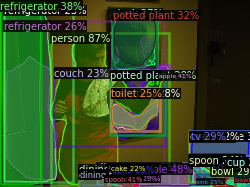

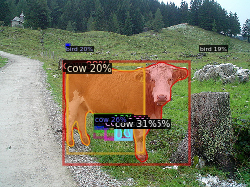

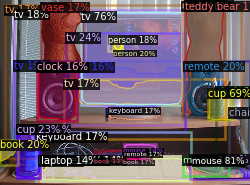

In [17]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cocoval_metadata,
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

***Performing Evaluation on Coco Validation 2017 Set***

In [10]:
evaluator = COCOEvaluator("coco_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[05/27 17:06:53 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /content/drive/MyDrive/instances_val2017.json
[05/27 17:06:54 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 10777        |   bicycle    | 314          |      car      | 1918         |
|  motorcycle   | 367          |   airplane   | 143          |      bus      | 283          |
|     train     | 190          |    truck     | 414          |     boat      | 424          |
| traffic light | 634          | fire hydrant | 101          |   stop sign   | 75           |
| parking meter | 60           |    bench     | 411          |     bird      | 427          |
|      cat      | 202          |     dog      | 218          |     horse     | 272          |
|     sheep     | 354          |     cow

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[05/27 17:06:58 d2.evaluation.evaluator]: Inference done 11/5000. Dataloading: 0.1669 s / iter. Inference: 0.0838 s / iter. Eval: 0.0371 s / iter. Total: 0.2878 s / iter. ETA=0:23:55
[05/27 17:07:03 d2.evaluation.evaluator]: Inference done 38/5000. Dataloading: 0.0921 s / iter. Inference: 0.0849 s / iter. Eval: 0.0338 s / iter. Total: 0.2109 s / iter. ETA=0:17:26
[05/27 17:07:08 d2.evaluation.evaluator]: Inference done 68/5000. Dataloading: 0.0749 s / iter. Inference: 0.0852 s / iter. Eval: 0.0311 s / iter. Total: 0.1913 s / iter. ETA=0:15:43
[05/27 17:07:13 d2.evaluation.evaluator]: Inference done 98/5000. Dataloading: 0.0679 s / iter. Inference: 0.0846 s / iter. Eval: 0.0317 s / iter. Total: 0.1843 s / iter. ETA=0:15:03
[05/27 17:07:19 d2.evaluation.evaluator]: Inference done 125/5000. Dataloading: 0.0742 s / iter. Inference: 0.0842 s / iter. Eval: 0.0314 s / iter. Total: 0.1899 s / iter. ETA=0:15:25
[05/27 17:07:24 d2.evaluation.evaluator]: Inference done 154/5000. Dataloading: 0.07

***Performing Evaluation on the Tiny Voc Training Dataset***

In [18]:
evaluator = COCOEvaluator("tiny_voc_train", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "tiny_voc_train")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [05/27 17:41:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 17:41:06 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/MyDrive/tiny_voc_coco_train.json
[05/27 17:41:06 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 797          |   bicycle    | 99           |      car      | 238          |
|  motorcycle   | 91           |   airplane   | 103          |      bus      | 111          |
|     train     | 87           |    truck     | 0            |     boat      | 99           |
| traffic light | 0            | fire hydrant | 0            |   stop sign   | 0            |
| parking meter | 0            |    bench     | 0            |     bird      | 130      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[05/27 17:41:09 d2.evaluation.evaluator]: Inference done 11/1349. Dataloading: 0.0566 s / iter. Inference: 0.0811 s / iter. Eval: 0.0139 s / iter. Total: 0.1517 s / iter. ETA=0:03:22
[05/27 17:41:14 d2.evaluation.evaluator]: Inference done 46/1349. Dataloading: 0.0475 s / iter. Inference: 0.0817 s / iter. Eval: 0.0177 s / iter. Total: 0.1470 s / iter. ETA=0:03:11
[05/27 17:41:19 d2.evaluation.evaluator]: Inference done 78/1349. Dataloading: 0.0541 s / iter. Inference: 0.0815 s / iter. Eval: 0.0178 s / iter. Total: 0.1535 s / iter. ETA=0:03:15
[05/27 17:41:24 d2.evaluation.evaluator]: Inference done 107/1349. Dataloading: 0.0627 s / iter. Inference: 0.0820 s / iter. Eval: 0.0172 s / iter. Total: 0.1619 s / iter. ETA=0:03:21
[05/27 17:41:30 d2.evaluation.evaluator]: Inference done 139/1349. Dataloading: 0.0629 s / iter. Inference: 0.0821 s / iter. Eval: 0.0171 s / iter. Total: 0.1622 s / iter. ETA=0:03:16
[05/27 17:41:35 d2.evaluation.evaluator]: Inference done 171/1349. Dataloading: 0.0